In [82]:
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import os


# Reading NiFTI Files .nii

In [83]:
def read_nii(file_name):
    '''
    Reads a NIfTI file and returns the data as a numpy array
    '''

    # reads the NIfTI file
    nii_file = nib.load(file_name)

    # Access the data
    data = nii_file.get_fdata()
    return data



# Visualize with Slider

In [84]:
def nifti_slider(data):
    '''
    Creates a slider to scroll through the slices of a 3D volume
    '''

    # Function to update plot
    def plot_slice(slice_number):
        plt.figure(figsize=(8, 8))
        plt.imshow(data[:, :, slice_number], cmap='gray')
        plt.show()

    # Create a slider
    max_slice = data.shape[2] - 1
    slider = widgets.IntSlider(min=0, max=max_slice, step=1, value=max_slice // 2)

    # Display the widget and the initial plot
    interactive_plot = widgets.interactive(plot_slice, slice_number=slider)
    display(interactive_plot)


# Getting Meta Data

Access the Header:
The NIfTI image object has a header attribute that you can use to access metadata.

In [29]:
def nifti_metadata(file_name):
    '''
    Reads a NIfTI file and returns the metadata
    '''

    # reads the NIfTI file
    nii_file = nib.load(file_name)

    # Access the header
    header = nii_file.header

    # Data Shape and Type
    print("Data Shape:", nii_file.shape)
    print("Data Type:", header.get_data_dtype())

    # Voxel Size
    print("Voxel Size:", header.get_zooms())

    # Affine Matrix (transformation matrix to map voxel indices to world coordinates):
    print("Affine Matrix:\n", nii_file.affine)

    # explore all rest
    print(header)


## color coding for the segmentation mask: 
- dark gray is negrotic, less active parts of the tumor or different types of tissue that are part of the tumor but not as actively growing or as aggressive as the parts represented in white. This could correspond to the necrotic (dead) parts of the tumor or non-enhancing tumor parts.
- white: is general tumor, core of the tumor, enhancing tumor (active tumor regions that show up brightly on contrast-enhanced scans),
- light gray in invasive, These regions could represent edema (swelling) or infiltration areas where the tumor is starting to affect nearby brain tissue but is not as dense as the core tumor regions. This might include the peritumoral edema or infiltrating tumor regions.

# Finding the slice with the largest tumor

In [85]:
# Load the original brain scan and the segmentation mask

def mask_slice (original_data, mask_data):
        '''
        Function to display the slice with the largest affected 
        area of the original MRI scan together with slice of segmentation mask

        Args: 
            original_data (numpy array): original MRI scan (already loaded from NIfTI file)
            mask_data (numpy array): segmentation mask (already loaded from NIfTI file)
        Returns:
            None
        '''

        # Initialize variables to track the largest slice
        max_non_black_count = 0
        max_slice_index = 0

        # Iterate through each slice in the mask
        for i in range(mask_data.shape[2]):
            # Count non-black (non-zero) pixels in the slice
            non_black_count = np.count_nonzero(mask_data[:, :, i])

            # Update max count and slice index if current slice has more non-black pixels
            if non_black_count > max_non_black_count:
                max_non_black_count = non_black_count
                max_slice_index = i

        print("Slice with the largest affected area:", max_slice_index)

        # Display the corresponding slices from both the original scan and the mask
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(original_data[:, :, max_slice_index], cmap='gray')
        axes[0].set_title('Original Brain Scan')

        axes[1].imshow(mask_data[:, :, max_slice_index], cmap='gray')
        axes[1].set_title('Segmentation Mask')

        plt.show()

        return max_slice_index


# Using Segmentation Mask to cut out tumor from slice

1. Find the slice with the largest tumor area
2. Use the segmentation mask for that slice to create a masked image. This involves setting all pixels to black (or zero intensity) where the mask is zero, and keeping the original pixel values where the mask is non-zero.
3. Display or return this masked image.

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def mask_slice(original_data, mask_data):
    '''
    Function to display and return the slice with the largest affected area of the tumor
    from the original MRI scan.

    Args: 
        original_data (numpy array): original MRI scan (already loaded from NIfTI file)
        mask_data (numpy array): segmentation mask (already loaded from NIfTI file)
    Returns:
        numpy array: image of the slice with the largest tumor
    '''

    # Initialize variables to track the largest slice
    max_non_black_count = 0
    max_slice_index = 0

    # Iterate through each slice in the mask
    for i in range(mask_data.shape[2]):
        # Count non-black (non-zero) pixels in the slice
        non_black_count = np.count_nonzero(mask_data[:, :, i])

        # Update max count and slice index if current slice has more non-black pixels
        if non_black_count > max_non_black_count:
            max_non_black_count = non_black_count
            max_slice_index = i

    print("Slice with the largest affected area:", max_slice_index)

    # Create a masked image
    masked_image = np.where(mask_data[:, :, max_slice_index] > 0, original_data[:, :, max_slice_index], 0)

    # Display the masked image: key line. It replaces all pixels in the original slice with zero intensity 
    # where the mask is zero, effectively 'cutting out' everything except the tumor. The result is an image 
    # that only shows the tumor from the slice with the largest tumor area.
    plt.imshow(masked_image, cmap='gray')
    plt.title('Masked Image of Tumor')
    plt.show()

    return masked_image



# Putting it together

In [93]:
#define file names
file_seg = "BraTS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_BraTS-GLI-00006-000_BraTS-GLI-00006-000-seg.nii.gz"
file_scanT1n = "BraTS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_BraTS-GLI-00006-000_BraTS-GLI-00006-000-t1n.nii.gz"
file_scanT1c = "BraTS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_BraTS-GLI-00006-000_BraTS-GLI-00006-000-t1c.nii.gz"
file_scanT2w = "BraTS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_BraTS-GLI-00006-000_BraTS-GLI-00006-000-t2w.nii.gz"
file_scanT2f = "BraTS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_BraTS-GLI-00006-000_BraTS-GLI-00006-000-t2f.nii.gz"


#read nifti files
original_data_T1n = read_nii(file_scanT1n)
original_data_T1c = read_nii(file_scanT1c)
original_data_T2w = read_nii(file_scanT2w)
original_data_T2f = read_nii(file_scanT2f)
mask_data = read_nii(file_seg)



In [ ]:
#read metadata
print(nifti_metadata(file_scan))


In [ ]:
print(nifti_metadata(file_seg))

Slice with the largest affected area: 69


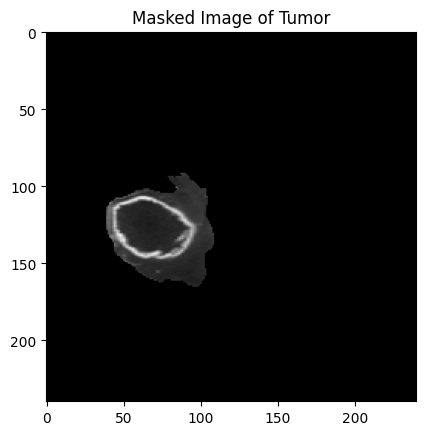

In [94]:
#display slices with biggest affected area
max_slice_index = mask_slice(original_data_T1c, mask_data)

In [111]:
#range of values in mask_data
print("Range of values in mask_data:", np.unique(mask_data))


Range of values in mask_data: [0. 1. 2. 3.]


Slice with the largest affected area: 69


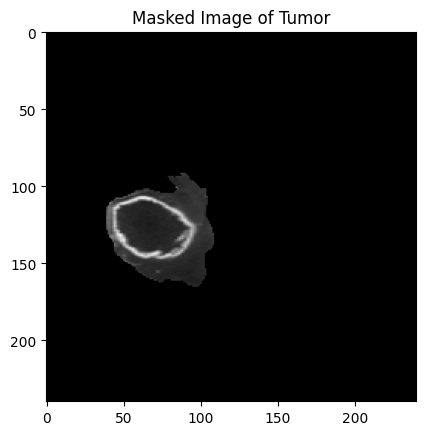

In [89]:
masked_tumor_image = mask_slice(original_data, mask_data)

68

In [97]:
#display slider
nifti_slider(original_data_T2w)

interactive(children=(IntSlider(value=77, description='slice_number', max=154), Output()), _dom_classes=('widg…

# Find certain file types 

In [106]:
import os

def find_scan_and_segm_files(root_dir):
    '''
    Finds the scan and segmentation files for all scan types in a directory.

    Args:
        root_dir (string): Path to the root directory
    Returns:
        dict: Dictionary containing paths to the scan files and the segmentation file
    '''
    
    scan_types = ['flair', 't1', 't1gd', 't2']
    scan_paths = {scan_type: None for scan_type in scan_types}
    seg_path = None

    # Define the file name patterns for segmentation
    seg_file_pattern = '_11_segm.nii'

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(seg_file_pattern):
                seg_path = os.path.join(root, file)
            else:
                for scan_type in scan_types:
                    scan_file_pattern = f'_11_{scan_type.upper()}.nii'
                    if file.endswith(scan_file_pattern):
                        scan_paths[scan_type] = os.path.join(root, file)

        # Check if all scan types and segmentation file are found
        if all(scan_paths.values()) and seg_path:
            scan_paths['segm'] = seg_path
            return scan_paths

    scan_paths['segm'] = seg_path
    return scan_paths




In [107]:

root_directory = 'NIFTI_data'
scan_paths = find_scan_and_segm_files(root_directory)


In [108]:
scan_paths

{'flair': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_FLAIR.nii',
 't1': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T1.nii',
 't1gd': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T1GD.nii',
 't2': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T2.nii',
 'segm': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_segm.nii'}

# Save as PNG

In [48]:
# Extract the specific slice
slice_to_save = original_data[:, :, max_slice_index]

In [49]:
# Normalize the slice data to the 0-255 range
normalized_slice = (slice_to_save - slice_to_save.min()) / (slice_to_save.max() - slice_to_save.min())
normalized_slice *= 255
normalized_slice = normalized_slice.astype('uint8')


In [56]:
from PIL import Image

# Convert to PIL Image for resizing
img = Image.fromarray(normalized_slice)
img_resized = img.resize((400, 400), Image.LANCZOS)  # Choose an appropriate interpolation method

# Save the resized image
img_resized.save('path_to_save_slice.png')


# Get cut-outs and slices for everythin

In [78]:
scan_paths

{'flair': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_FLAIR.nii',
 't1': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T1.nii',
 't1gd': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T1GD.nii',
 't2': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_structural/UPENN-GBM-00002_11_T2.nii',
 'segm': 'NIFTI_data/UPENN-GBM-00002/UPENN-GBM-00002_11_segm.nii'}

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def mask_slices(original_data_t1, original_data_t1c, original_data_t2, original_data_flair, mask_data):
    '''
    Function to display and return slices from four different MRI scan types and 
    their segmented versions with the largest tumor area.

    Args: 
        original_data_t1 (numpy array): T1 MRI scan
        original_data_t1gd (numpy array): T1GD MRI scan
        original_data_t2 (numpy array): T2 MRI scan
        original_data_flair (numpy array): FLAIR MRI scan
        mask_data (numpy array): segmentation mask
    Returns:
        dict: dictionary containing slices and segmented slices for each scan type
    '''

    # Initialize variables to track the largest slice
    max_non_black_count = 0
    max_slice_index = 0

    # Iterate through each slice in the mask
    for i in range(mask_data.shape[2]):
        non_black_count = np.count_nonzero(mask_data[:, :, i])
        if non_black_count > max_non_black_count:
            max_non_black_count = non_black_count
            max_slice_index = i

    print("Slice with the largest affected area:", max_slice_index)

    # Function to create masked image
    def create_masked_image(original_data, mask_slice):
        return np.where(mask_slice > 0, original_data, 0)

    # Gather the slices and segmented slices
    slices = {
        'mask_slice': mask_data[:, :, max_slice_index],
        't1_slice': original_data_t1[:, :, max_slice_index],
        't1c_slice': original_data_t1c[:, :, max_slice_index],
        't2_slice': original_data_t2[:, :, max_slice_index],
        'flair_slice': original_data_flair[:, :, max_slice_index],
        't1_segmented': create_masked_image(original_data_t1[:, :, max_slice_index], mask_data[:, :, max_slice_index]),
        't1c_segmented': create_masked_image(original_data_t1c[:, :, max_slice_index], mask_data[:, :, max_slice_index]),
        't2_segmented': create_masked_image(original_data_t2[:, :, max_slice_index], mask_data[:, :, max_slice_index]),
        'flair_segmented': create_masked_image(original_data_flair[:, :, max_slice_index], mask_data[:, :, max_slice_index])
    }

    # Display the slices (optional)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, (key, image) in enumerate(slices.items()):
        ax = axes[i // 3, i % 3]
        ax.imshow(image, cmap='gray')
        ax.set_title(key)
        ax.axis('off')

    plt.show()

    return slices




Slice with the largest affected area: 69


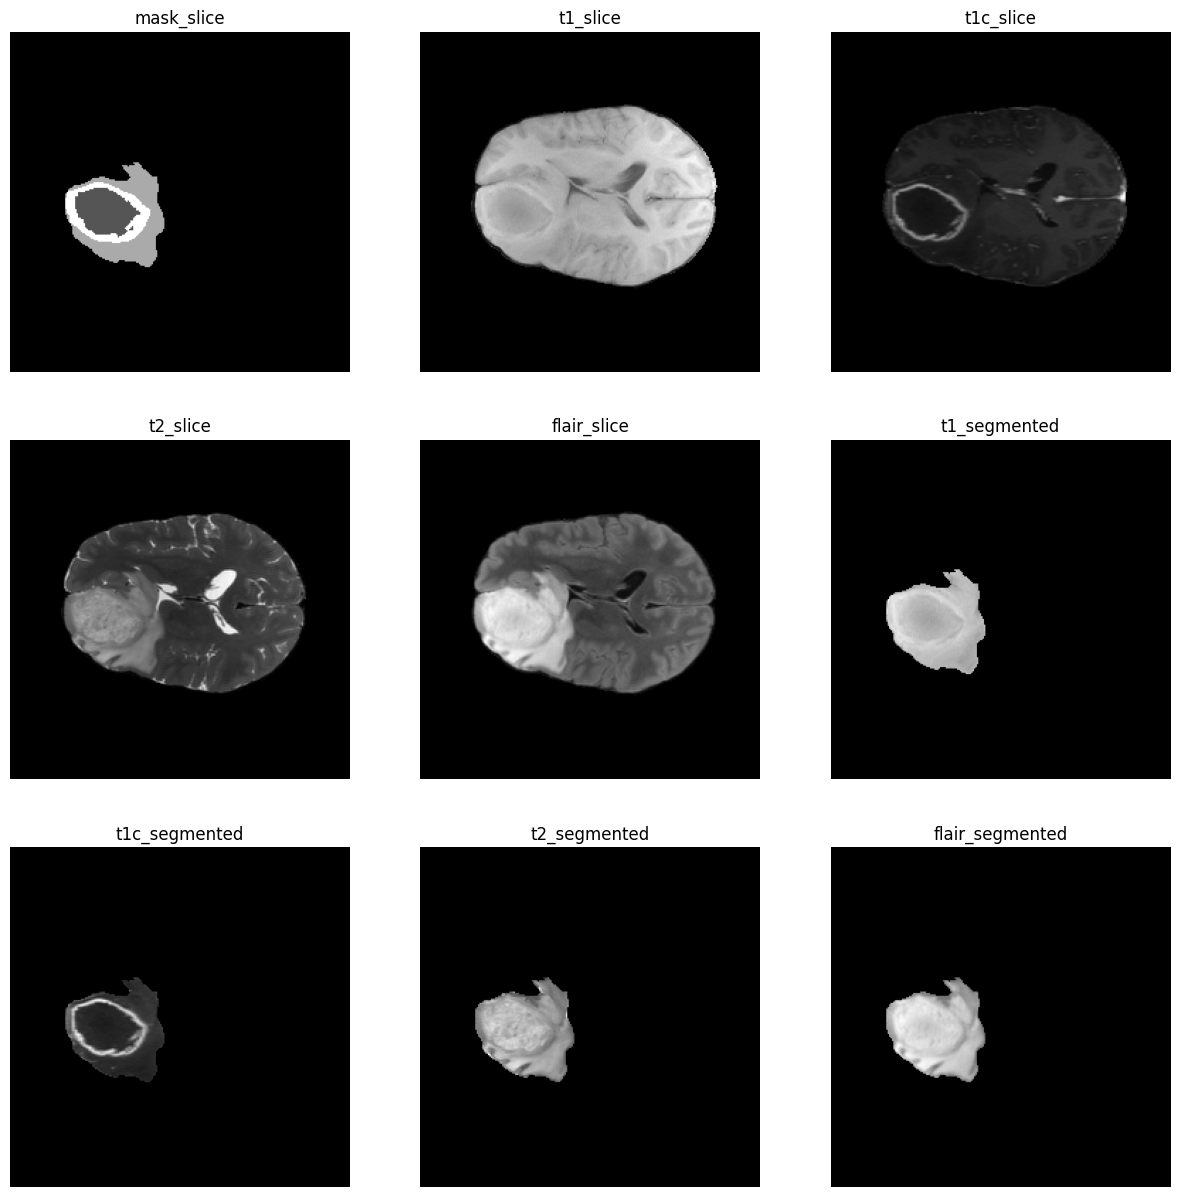

In [103]:

slices = mask_slices(original_data_T1n, original_data_T1c, original_data_T2w, original_data_T2f, mask_data)

In [104]:
#define file names
file_seg = "BraTS/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_Additional_BraTS-MET-00163-000_BraTS-MET-00163-000-seg.nii.gz"
file_scanT1n = "BraTS/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_Additional_BraTS-MET-00163-000_BraTS-MET-00163-000-t1n.nii.gz"
file_scanT1c = "BraTS/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_Additional_BraTS-MET-00163-000_BraTS-MET-00163-000-t1c.nii.gz"
file_scanT2w = "BraTS/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_Additional_BraTS-MET-00163-000_BraTS-MET-00163-000-t2w.nii.gz"
file_scanT2f = "BraTS/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_Additional_BraTS-MET-00163-000_BraTS-MET-00163-000-t2f.nii.gz"


#read nifti files
original_data_T1n = read_nii(file_scanT1n)
original_data_T1c = read_nii(file_scanT1c)
original_data_T2w = read_nii(file_scanT2w)
original_data_T2f = read_nii(file_scanT2f)
mask_data = read_nii(file_seg)

Slice with the largest affected area: 39


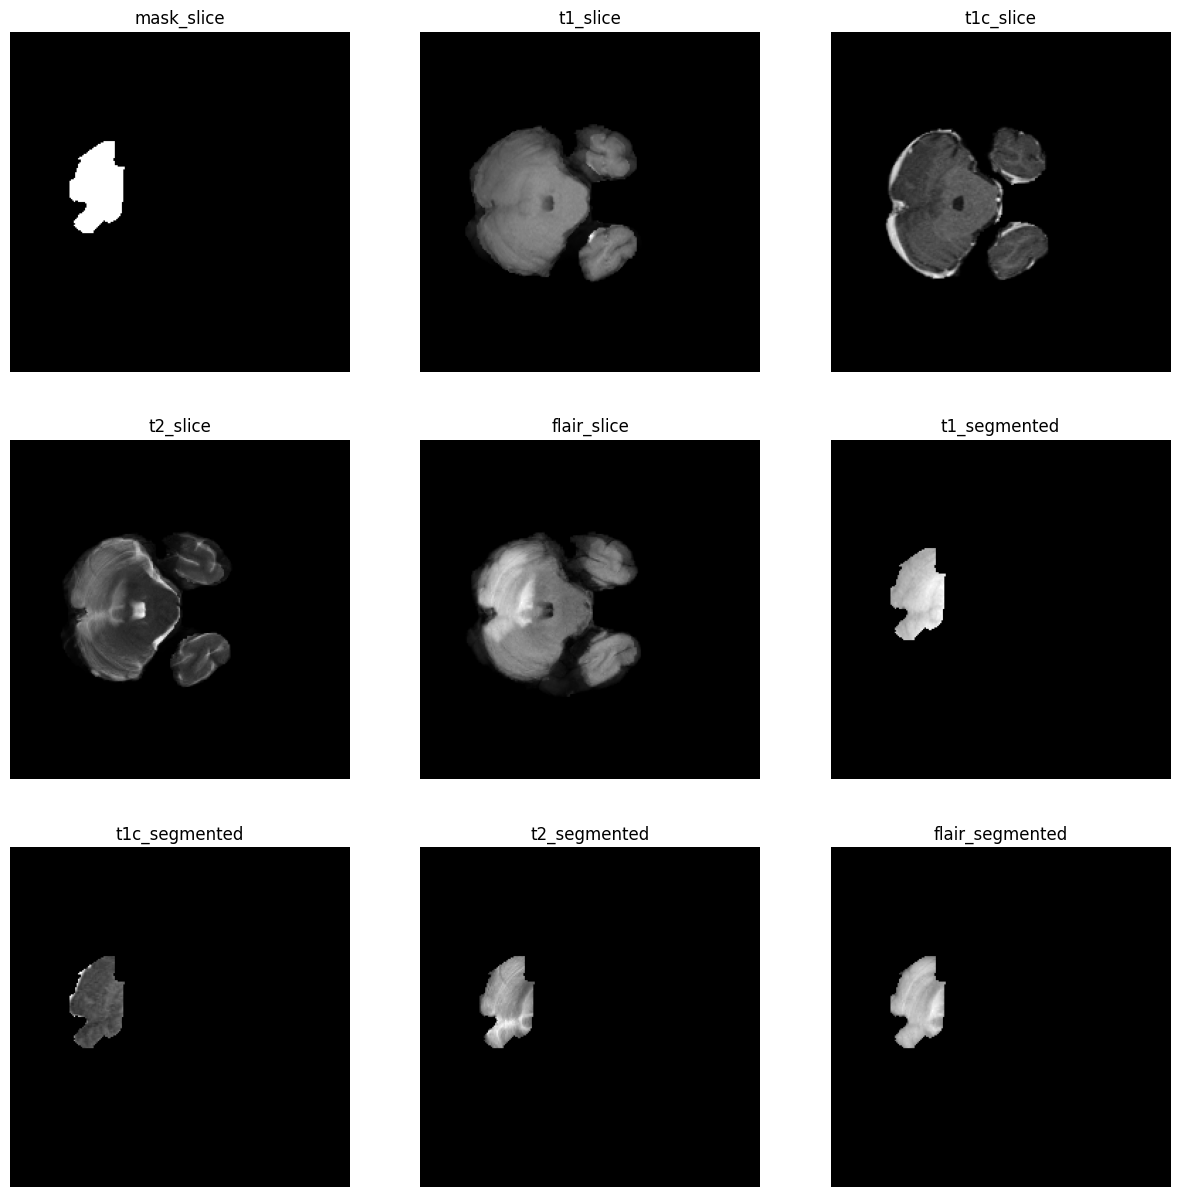

In [105]:

slices = mask_slices(original_data_T1n, original_data_T1c, original_data_T2w, original_data_T2f, mask_data)